# 18. 强化学习

强化学习是现今机器学习领域中，最令人兴奋并且最古老的研究领域。从20世纪50年代至今，强化学习领域诞生出了许多有趣的应用，尤其在游戏领域以及机器控制领域，但它从未获得过多的关注。直到2013年，DeepMind演示了一个可以从零开始学习玩任何雅达利游戏（Atari game）的系统，其在游戏中的表现超越了大多数的人类。有趣的是，该系统仅仅依靠原始的游戏画面像素作为输入，并不具备该游戏的任何先验知识；2016年，DeepMind开发的基于深度强化学习的AlphaGo系统击败了两名职业围棋选手李世石和柯洁。2014年， DeepMind以5亿美元的价格被Google收购。

DeepMind实现这些成就的根本原因是将深度学习的方法引入了强化学习领域。本章将首先介绍强化学习的基本概念以及其擅长解决的问题，然后展示深度强化学习（Deep Reinforcement Learning）中的两种基本技术：policy gradients 和 deep Q-networks(DQNs), 其中涉及对马尔可夫决策过程（Markov decision processes, MDPs）的讨论。在讨论过程当中，我们将使用提到的技术分别训练模型来平衡移动小车上的杆子，从而展示其性能；然后我们会介绍TF-Agents库，其中集成了最先进的强化学习算法并简化了强化学习系统的搭建；进一步，我们会使用TF-Agents训练著名的雅达利游戏Breakout。最终我们会探讨强化学习领域的研究前沿。

## 定义：学习以优化奖励

定义：强化学习中，一个agent通过在环境（environments）中进行观察（observations）并采取行动（actions）来获取奖励（rewards）。其学习目标是找到一种行动策略（policy）使得其在时间尺度上获取的平均奖励最大化。学习过程类似于生物体的趋利避害，agents在学习的过程中通过不断试错（trails and error）来最大化“利”而最小化”害“。

应用：在以上定义下，强化学习可以应用于广泛的研究任务。例如：
1. Agents作为控制机器人的程序。

2. Agents作为控制Ms.Pac-Man的程序。

3. Agents作为围棋等棋类游戏的玩家。

4. Agents作为一个自动调温程序。

5. Agents进行作为炒股机器人。

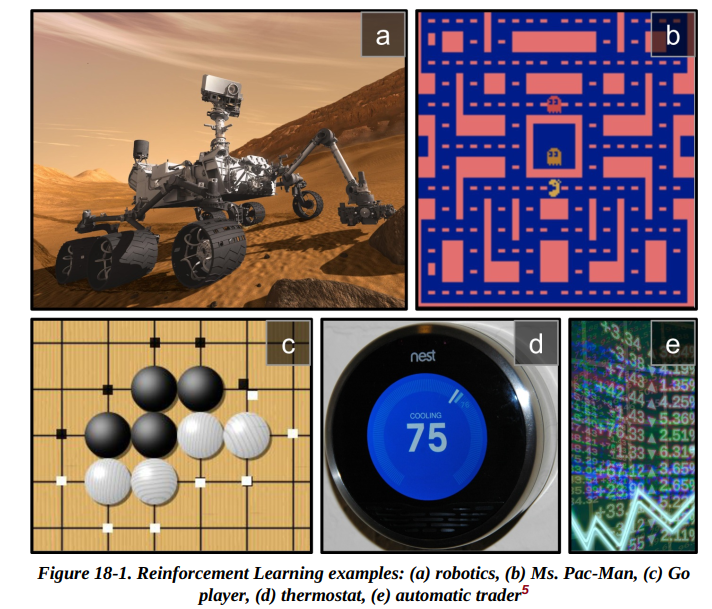


## 基本思想：策略搜索（Policy Search）

强化学习中，Agents用以决定其行为的算法称为策略（Policy）。最简单的，一个神经网络算法如果将observations作为输入，将action作为输出，那么该神经网络算法就是一个Policy。Policy可以是任何算法，并且不需要是确定性的算法，甚至不需要通过observations来得到。以吸尘器机器人为例：

机器人Alice的reward是其30分钟内吸起的灰尘总量。其policy可以是每秒钟以概率p直接前行，或者以概率1-p旋转角度r后前进。由于这个policy涉及到随机性，因此称为随机策略（stochastic policy）。在这个policy下，Alice的轨迹是不确定的，但这也保证了Alice会遍历屋子里的所有地面。问题是，这个policy的参数p和r如何设定才会让Alice在30分钟内吸起灰尘量最大呢?

这个policy的学习涉及到p和r两个参数的学习。一种简单的学习办法是尝试大量的参数取值，选取最终效果最好的，但这种策略搜索方法太暴力也太低效，当策略空间很大的时候，这种方法无异于大海捞针。另一种办法是使用遗传算法探索策略空间。例如，随机初始化100个策略，去除其中最差的80个，剩余的20个每个再繁衍4个子代，繁衍子代的方法是复制父代再添加一定的随机变异，持续繁衍多代直到找到符合标准的策略。还有一种方案是使用优化方法，也就是计算reward关于参数的梯度，利用梯度上升法进行policy的搜索，这种方法称为policy gradients(PG)。回到吸尘器的例子，可以尝试轻微的增大p的取值，如果reward因此而增加，那么就增大p, 反之则减小。我们将利用TensorFlow实现一个流行的PG方法，但在此之前，我们首先搭建一个可以让agent存在的环境，为了实现这一点，我们引入OpenAI Gym.

## 仿真工具：OpenAI Gym

强化学习一个重要挑战就是在训练一个agent的时候，需要创建一个工作环境。比如，我们想要用强化学习来训练agent玩Atari游戏，则需要一个Atari游戏模拟器。换句话说，训练在现实场景中是非常艰难和缓慢的，因此通常需要一个仿真环境。例如，使用PyBullet或者MuJoCo来进行3D物理建模。

OpenAI Gym是一个提供了大量仿真环境的工具箱（Atari游戏，棋类游戏，2D或3D建模等），基于此我们可以训练Agents，对它们进行对比，或者设计新的强化学习算法。在安装OpenAI Gym之前，如果你创建了一个独立的虚拟环境

In [6]:
import gym
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.03446383,  0.00451308, -0.02361187, -0.04405911])

In [9]:
env.render()

True

如果想以numpy数组的形式输出render命令得到的图像，那么可以设定mode="rgb_array":

In [3]:
img=env.render(mode="rgb_array")
img.shape

(400, 600, 3)

现在，我们查询environment中的action space：

In [4]:
env.action_space

Discrete(2)

Discrete(2)的含义是在目前定义的CartPole的环境中只支持0和1两个操作，换句话说，action space仅包含0和1，也就是要么向左加速（0），要么向右加速（1）。在其他的环境中或许有更大的action space，甚至是连续型的。由于此时小车上的杆子是向右倾斜的（obs[2]>0），因此我们尝试让小车向右加速：

In [3]:
action=1
obs,reward,done,info=env.step(action)
obs

array([ 0.03429544,  0.2013078 ,  0.01395769, -0.31605449])

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
info

{}

Step()方法执行给定的action,并返回4个值：

`obs`: 代表了新的observation. 目前，小车在向右移动(obs[1]>0)，杆子仍然向右倾斜(obs[2]>0)，但其角速度是负的(obs[3]<0)，因此杆子很可能下一步就会偏向左边。

`reward`：在这个环境当中，无论你在每一步采取了什么action，都会得到一个1.0的奖励，因此训练目标是使得这个episode一直向下运行，即杆子一直在小车上保持平衡。

`done`: 代表当前episode是否结束，结束即为true。此环境中，episode结束的标志是：当杆子倾斜太多或者离开屏幕时，或者当前episode已经进行了200步（这意味着你已经赢了）。episode结束后，必须重置环境以进行下一个episode。

`info`: 这个环境特定的字典负责提供一些关于debug或者训练的额外信息。比如，在某个游戏里面，它可能指出agent还有多少条命。

> `Tips:一旦某个environment使用结束，应该调用close()函数释放资源。`


接下来我们实现一个简单的policy：当杆子偏向左时小车向左加速，偏向右时小车向右加速。然后基于此策略连续执行500个episodes.

In [4]:
def basic_policy(obs):
    angle=obs[2]
    return 0 if angle<0 else 1
totals=[]
for episode in range(500):
    episode_rewards=0
    obs=env.reset()
    for step in range(200):
        action=basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [5]:
import numpy as np
np.mean(totals), np.std(totals),np.mean(totals),np.max(totals)

(42.562, 9.128754350950627, 42.562, 66.0)

可以看出，在现有策略(policy)下，即使进行了500次尝试，也没有一次成功让杆子在小车上方坚持超过68个step，这显然是一个糟糕的策略。接下来我们考虑能否利用神经网络找到更好的策略(policy)。

## 基于神经网络的策略

利用神经网络寻找policy的基本思想是：以当前observation为输入，下一步action为输出，中间是黑盒子。事实上，我们期望神经网络在action空间上输出一个概率分布, 而下一步的action就从这个概率分布中随机采样得到。通俗的讲，在当前小车承杆的仿真环境中，我们希望神经网络告诉我们小车向右加速和向左加速的概率分别是多大，然后根据具体的概率决定向左还是向右。比如，向左向右的概率分别是30%和70%，那么我们就以30%的概率向左，70%的概率向右。相比于直接比较概率大小然后决定向左向右的方法，这种依概率随机采样的方法保留了agent探索更多action的能力。

In [8]:
import tensorflow as tf
from tensorflow import keras

n_inputs=4 # == env.observation_space.shape[0]

model=keras.models.Sequential([
    keras.layers.Dense(5,activation="elu",input_shape=[n_inputs]),
    keras.layers.Dense(1,activation="sigmoid"),
])

以上我们基于keras的sequential模块建立了一个policy network。其中网络输入为观察空间的大小，网络隐含层为一个5个units组成的全连接层，输出为1维，代表小车向左加速的概率，如果action space的中有更多的action选择，可以选择设置更多的输出，并利用softmax进行归一化。

### Action 评估：信用分配问题

如果已知每一步的最佳action是什么，我们就可以通过最小化目标概率分布与估计概率分布之间的交叉熵来训练神经网络，此时策略学习问题就成为了一个普通的有监督学习问题。然而，agents在强化学习中的指导往往只有稀疏并且存在延迟的奖励。试想，杆子在小车上坚持了100个steps，但agent如何知道在这100次action中具体哪些是好的，哪些是坏的。它只知道在最后一次action后，杆子从小车上掉了下去，但显然这个掉落不完全由最后一个action导致。换句话说，如果一个agent得到了某一个奖励，但它并不知道是因为具体哪些action激发了这个奖励，这个问题称为`信用分配问题`。

为了解决`信用分配问题`，即实际评判一个action的好坏，一个常见的策略是基于该action之后所有奖励的和来评判，通常还会为每一步的奖励引入一个折旧因子$\gamma$来加权。这个基于折旧因子的加权奖励和被称为该action的return。试想，一个agent决定连续采取3次向右行进的动作，第一次得到了$+10$的奖励，第二次得到了0，第三次得到了$-50$的奖励。假设折旧因子$\gamma=0.8$，那么第一个action的return为$10+\gamma\times0+\gamma^{2}\times(-50)=-22$。如果折旧因子接近于0，未来的奖励相比于即时奖励几乎可以忽略不计；反之，如果折旧因子接近于1，那么未来获取的奖励和即时奖励几乎占据一样的权重。$\gamma$通常会取$0.9$到$0.99$之间的某个值。当$\gamma=0.95$，第13次action的reward比重将降低到$0.5$（$0.95^{13}\approx0.5$），然而当$\gamma=0.99$，则需要69步，reward比重才会降低到$0.5$。因此，看起来$\gamma=0.95$是比较合理的。

>`问题：如果每一步都存在一个reward的话，岂不是从一开始就知道了每个action的好坏，为什么还要费尽心思利用return来评判呢？reward对于一个action的价值评判与return有什么区别？`

诚然，不可避免地，在游戏过程中，一个好的action后续可能会跟随着一些坏的actions使得杆子掉落的更快，从而使得一个好的action却得到了一个较低的return。但是，如果我们进行足够多次游戏，平均意义上好的action通常会得到更高的return。在一个可执行的算法当中，我们需要量化某个action在平均意义上会比其他可能的action好多少或者坏多少（动作优势，action advantage）。这一点，我们可以通过进行多个episodes并且对所有动作的return进行归一化（减去均值再除以标准差）来实现。在此之后，我们就可以合理的假设那些得到了负的advantage的action是坏的，而得到了正advantage的action是好的。okay,现在已经得到了评估一个action的方法，接下来我们利用该方法训练一个agent。

### Policy Gradients

Policy Gradients（PG）的基本思想是通过梯度下降的方法优化policy的参数从而实现更高的奖励。一类经典的PG方法是1992年提出的`REINFORCE`算法，下面介绍一个`REINFORCE`算法的常见变体：

> Step1: 首先, 让agent根据基于神经网络的policy玩很多次游戏。并且在每一步，计算使所选action更有可能发生的梯度并保存（比如：损失函数是将被选action为groundtruth的交叉熵，参数是神经网络的权重以及偏倚参数）。但是暂时不使用这些梯度；

> Step2: 一旦游戏进行了多个episodes，计算每一个action的优势（利用上一节介绍的方法）；

> Step3: 如果某个action的优势是正的，说明这个action很可能是好的，那么我们希望能够应用之前计算的梯度，以使该action在未来更有可能被选择。反之亦然。要实现这一点，我们只需要将每一个梯度向量乘以对应action的优势；

> Step4: 最终，计算所有导致的梯度向量的均值，并且利用该均值来进行梯度下降；

现在我们使用tf.keras来实现这个算法。继续考虑小车承杆的场景，我们将利用神经网络来让杆子在小车上实现平衡。首先，我们需要一个函数来执行每一个action。不妨，我们先让每一个action选取都向右，这使得我们可以计算loss和对应的梯度。

In [9]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

简单解释一下上述代码：

- 在GradientTape模块中，首先建立模型，以观察为输入，action为左的概率 left_proba为输出。

- 接下来，我们在$[0,1]$区间随机采一个数，如果这个数大于left_proba，则action为向右($action=1$)，否则，action为向左($action=0$)。

- 接下来，定义向左的目标概率: $y_{target}=1-action$。

- 然后利用给定的损失函数计算损失，并关于模型变量计算梯度。要注意的是：这些梯度并不立即使用，而是需要根据计算的优势来判断action的真正好坏。

- 最后，执行所选的action，并且返回得到的obsevation,reward,以及当前episode是否结束等相关信息。

现在，依据play_one_step()函数来创建另一个函数play_multiple_episodes()来执行多个episodes，并返回每个episodes中每个step对应的reward和梯度信息：

In [10]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model,loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

play_multiple_episodes()返回了rewards的列表（每一个episode对应一个reward列表，每个列表包含了每一步的奖励信息）以及梯度列表（每个episode对应一个梯度列表，而每一个梯度列表包含了每一步的梯度信息）

In [2]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

discount_rewards()函数返回了折旧后的reward信息。而discount_and_normalize_rewards()函数则进一步计算出了episodes中每一个action的优势大小。注意第一个episode比第二个episode要差，因此第一个episode中每一个action的优势都是负的；也就是说第一个episode中每一个action都会被认为是不好的action。

接下来直接实现算法！首先定义超参如下：

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

定义优化器以及损失函数：

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

建立并运行training loop：

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
    env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
    discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)],axis=0)
                    all_mean_grads.append(mean_grads)
                    optimizer.apply_gradients(zip(all_mean_grads,model.trainable_variables))

代码解释：

- 每一次迭代中，training loop调用play_multiple_episodes()函数，玩10次游戏，并返回相应的reward和梯度信息。

- 然后调用 discount_and_normalize_rewards()函数来计算每一个action的优势final_reward。

- 接下来，利用final_reward信息为梯度信息加权取平均。

- 最后，利用平均梯度进行模型优化。

以上代码可以成功的学习出好的策略并在小车承杆游戏中成功将杆子平衡在小车上（即，每一个episode的reward都接近200）。

以上简单的policy gradients算法可以解决小车承杆问题，但是并不能扩展到更大更复杂的任务中。在更复杂的任务中，采样往往是不充分的，需要进行很长时间的探索才能够真正取得进展。这是由于因为需要跑很多个episodes才能准确评估每一个action的优势。但是policy gradients算法为后续更有效的`Actor-Critic`算法的出现奠定了基础。

policy gradients算法是利用梯度下降法最大化rewards来直接优化policy。而另一种方法则不那么直接，其试图评判每一个状态，每一个action的好坏，从而决定如何选择action。为了充分理解该算法的思想，我们首先引入马尔可夫决策过程。

### 马尔可夫决策过程（Markov Decision Processes）

在20世纪早期，数学家马尔可夫研究了一种无记忆的随机过程，即`马尔可夫链`（Markov Chain）。`马尔可夫链`只有有限个状态，其每一步都会随机地从一个状态 $s$ 转移到另一个状态 $s'$。转移概率是固定的，并且仅仅取决于状态对 $(s,s')$，而不受之前状态的影响（这就是我们说这个系统无记忆的原因）。

`马尔可夫决策过程`（Markov Decision Process, MDP）在20世纪50年代由理查德·贝尔曼引入。`马尔可夫决策过程`类似于`马尔可夫链`，但做了一些改变：在每一步，agent首先从action空间中选取一个action, 然后再进行状态的转移，转移概率则取决于选取的action。一些状态转移会返回一些reward（正或者负），而agent的目标则是找到一个可以在时间尺度上最大化reward的policy。

贝尔曼给出了估计某个状态 $\textbf{s}$ 的最优状态值 $V^{*}(s)$ 的方法，$V^{*}(s)$ 的含义是：假设agent按照最优方式运行，其在期望意义上，可获得的所有未来奖励在折旧因子加权后的总和。贝尔曼证明了如果agent按照最优的方式运行，那么`贝尔曼最优方程`满足。这个递归方程指出如果agent的行为是最优的，那么当前状态的最优值就等于它采取一次最优action后得到的平均回报，加上这次action可能导致的所有状态的期望意义上的最优值。
>贝尔曼最优方程：$V^{*}(s)=\max_a{\sum_{s'}{T(s,a,s')[R(s,a,s')+\gamma\cdot V^{*}(s')]}}$， $\forall s$

方程中，$T(s,a,s')$表示agent在状态 $s$ 选取动作 $a$ 后转移到状态 $s'$ 的概率, $R(s,a,s')$ 表示该步转移获取的奖励，$\gamma$ 表示折旧因子。

这个方程给出了一个直接估计最优状态值的算法：首先将所有的状态最优值初始化为0，然后利用`值迭代方程`持续优化。一个出色的结果是，给定足够的迭代次数，这些估计一定回收敛到与最优策略相关的最优状态值。
>值迭代方程：$V_{k+1}(s)\leftarrow \max_a{\sum_{s'}{T(s,a,s')[R(s,a,s')+\gamma\cdot V_{k}(s')]}}$， $\forall s$

在这个方程中，$V_{k}(s)$ 是状态 $s$ 在算法的第 $k$ 次迭代的状态最优值的估计。

> `NOTE: 这个算法是一个典型的动态规划问题解法，其将复杂问题转化为可解的子问题进行迭代求解。`

利用以上方法我们可以求出每个状态的最优状态值，这个值在评估一个policy的时候会非常有用，但却无法直接提供一个最优的policy。幸运的是，贝尔曼找到了一个类似的方法来估计最优的`状态-动作值 (state-action value)`, 也就是所谓的 `Q-值（Quality Values）`。一个`状态-动作`对儿的`Q-值` $Q^{*}(s, a)$ 的含义是在状态 $s$ 的agent选取了动作 $a$ 之后所能期望的平均未来折现回报的总和。它奏效的模式如下：

首先将所有的 `Q-值` 初始化为0，然后利用 `Q-值迭代方程` 进行更新：

>Q-值迭代方程：$Q_{k+1}^{*}(s, a)\leftarrow \sum_{s'}{T(s,a,s')[R(s,a,s')+\gamma\cdot\max_{a'}{ Q_{k}^{*}(s, a')}]}$， $\forall (s', a)$

一旦我们掌握了最优的`Q-值`，定义最优策略$\pi^{*}{(s)}$就非常简单了:当agent在状态 $s$ 的时候，应当选择具有最高`Q-值`的动作，则是最优的动作，即 $\pi^{*}(s)=argmax_a{Q^{*}(s, a)}$。

### 时间差分学习（Temporal Difference Learning）

如上所述，离散动作空间的强化学习问题可以被建模为马尔可夫决策过程（MDP），但是实际操作中，agent在初始的时候往往并不知道转移概率 $T(s,a,s')$ 和 奖励 $R(s,a,s')$  的确切大小。因此agent至少需要经历一次完整的状态转移才会清楚具体的reward大小，而至少要进行多次完整的转移才可以较为准确的估计转移概率 $T(s,a,s')$ 的大小。

时间差分学习（Temporal Difference Learning，TD learning）算法实际上类似于`值迭代算法`，不同的地方是TD Learning假设agent仅仅知道部分MDP的知识，这与我们实际中面临的情况是吻合的。因为在实际中，agent通常只知道自身可能的状态以及可能进行的动作，而不具备更多的额外知识。为了解决现实中agent知识不足的问题，我们可以采用策略探索的方法--比如采用完全随机的策略--来探索MDP的更多知识。而随着探索的进行，agent也会根据自身实际的转移经历以及获取的reward来更新对于最优状态值的估计。

>TD Learning算法： $V_{k+1}(s)\leftarrow (1-\alpha)V_{k}(s)+\alpha(r+\gamma\cdot V_k(s'))$

或者，等价形式为:

> $V_{k+1}(s)\leftarrow V_{k}(s)+\alpha\cdot \delta_{k}(s,r,s')$，其中 $\delta_{k}(s,r,s')=r+\gamma\cdot V_k(s')-V_{k}(s)$

其中，$\alpha$ 为学习率参数；$r+\gamma\cdot V_k(s')$ 称为`TD 目标(TD target)`; $\delta_{k}(s,r,s')$ 称为`TD 误差(TD error)`。为简单期间，我们通常也会把方程写为 $a\leftarrow_{\alpha}b$，其含义是$a_{k+1}\leftarrow (1-\alpha)a_k+\alpha\cdot b_k$。因此，TD Learning算法的迭代表达式也可以写为：$V(s)\leftarrow_{\alpha}r+\gamma\cdot V(s')$。

>`TIP: TD learning方法与随机梯度下降（SGD）有许多相似之处，尤其是两者每一次只处理一个样本。就像SGD一样，TD learning 方法只有不断降低学习率才能真正收敛。`

对于每一个状态 $s$，该算法只跟踪agent离开该状态时获得的即时回报的运行平均值，加上它期望稍后获得的回报。

### Q-Learning

类似的，Q-Learning 算法也是在agent关于MDP知识不足的情况下Q-值迭代算法的变体。Q-Learning 的基本思想是让agent不断地探索，然后逐渐基于探索的知识提升关于Q-值的估计。一旦得到了一个精确的Q-值，最优策略则是在每一步选取具有最高Q-值的行为（贪心策略）。

> Q-learning 算法： $ Q(s, a)\leftarrow_{\alpha}r+\gamma\cdot \max_{a'}Q(s',a')$ 

对于每一个“状态-行为”对儿$(s,a)$， Q-learning 算法追踪其在时间尺度上通过离开状态$s$并采取 action $a$的平均reward，加上其期望意义上折旧的未来reward。为了估计这个加和，我们取下一状态$s'$上所有Q值估计的最大值，因为我们假设目标策略是最优的。

我们来尝试实现Q-Learning 算法。首先，我们将需要agent对环境进行探索。为了实现这一点，我们需要一个step 函数使得agent可以执行一个action并得到相应的state 和 reward。

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
return next_state, reward

现在我们尝试实现这个agent的探索策略。由于状态空间是非常小的，一个简单的随机策略就足够了。如果我们运行算法足够长时间，那么agent将会访问每一个状态很多次，并且尝试每个action很多次：

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

接下来，在我们像之前一样初始化了Q-值之后，我们已经准备好运行Q-Learning算法了。

In [ ]:
alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
for iteration in range(10000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

这个算法将会收敛到最优的Q-值，但是它将会消耗很多次迭代，并且大量的超参数微调。如下图所示，Q-值迭代算法（左）可以在20步迭代中很快收敛，然而Q-Learning算法（右）需要耗费8000步迭代来收敛。显然，不知道转移概率或者reward的大小会使得最优策略的搜索变得异常艰难！
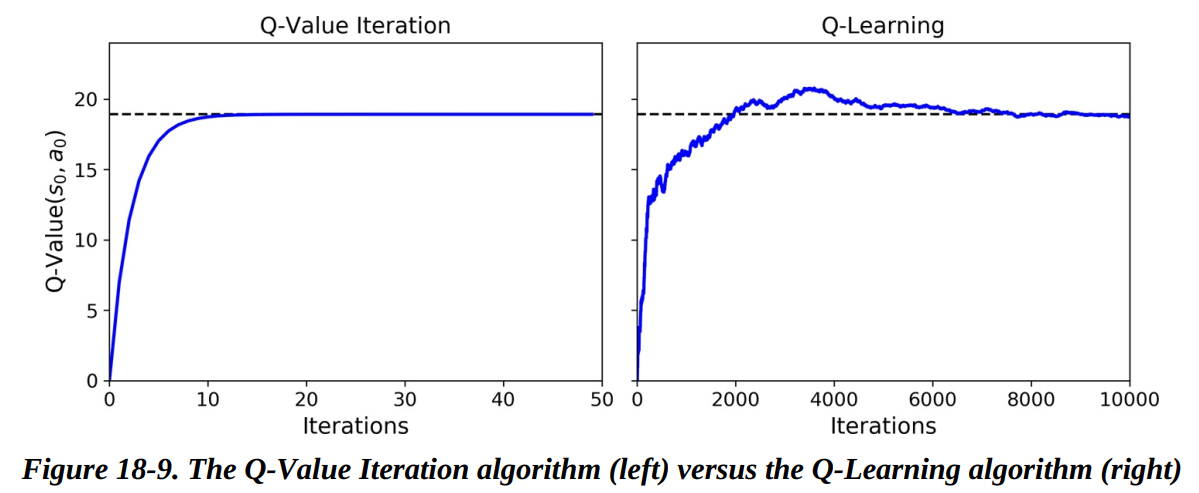

Q-Learning算法又被称为"off-policy"算法，原因是训练出来的policy通常并不必然是在训练过程中被执行的那一个；就像之前的代码示例，被执行的policy中每一步action的选取是完全随机的，然而训练出来的policy通常是选择具有最高Q-值的action，这在一定程度上是令人惊叹的，因为Q-Learning算法可以通过仅仅观察随机的策略而学习到最优的策略。

#### Exploration Policies

Q-Learning奏效的前提是随机探索的方式可以充分探索MDP中的知识，包括转移概率以及reward的值。尽管一个纯粹随机的策略可以保证agent在充分多的转移次数中访问到每一个状态并经历每一次转移，然而这需要花费极长的时间。因此，一个更好的选择是使用$\epsilon-greedy$ 策略：即每一步以概率 $\epsilon$ 随机选取action,而以概率 $1-\epsilon$ 贪心的选取行为（例，选取具有最高Q-值的行为）。$\epsilon-greedy$ 策略的优势是：随着Q-值的估计越来越准，更多的训练时间将会花费在环境中真正感兴趣的部分，同时会将少量的时间用于探索未知的部分。通常的做法是一开始将$\epsilon$设为一个较大的值（如，1.0）然后逐渐的降低（如，降低到0.05）。

还有一种替代的策略探索方案，即与其仅仅依赖于一定的几率来探索MDP，不如直接鼓励agent尝试之前没有尝试过的action。这可以作为一个实现Q-值估计的bonus，如下所示。
> $ Q(s, a)\leftarrow_{\alpha}r+\gamma\cdot \max_{a'}f(Q(s',a'),N(s',a'))$ 

其中：
> $N(s',a')$计量了action$a'$在状态$s$时被选取的次数；
> $f(Q,N)$是探索函数，比如：$f(Q,N)=Q+K/(1+N)$，其中$K$代表了对于未知行为的好奇程度，是一个超参数。

#### Approximate Q-learning and Deep Q-Learning 

Q-Learning的主要问题是难以扩展到状态空间或者行为空间很大的MDP场景当中。例如，我们希望训练一个agent来玩"MS.Pac-Man"游戏，游戏环境中存在150个小球可供角色MS.Pac-Man来吃，而每个小球的状态可以是"present"或者"absent（表示小球已经被吃掉）"。此时，游戏中状态空间的维度可以达到$2^{150}$，这是一个不可思议的数字，理论上我们无法通过随机策略来准确评估每一个”状态-行为“对的Q-值。
 
解决方案是找到一个函数 $Q_{\theta}(s,a)$ 来逼近任意 $(s,a)$ 的 Q-值，而函数参数 $\theta$ 的维度是可控的。这种解法称为逼近Q-Learning(Approximate Q-Learning)。之前通用的逼近函数形式是线性函数，即先从状态中手工提取特征，然后对这些特征线性组合得到函数 $Q_{\theta}(s,a)$。直到2013年，Deepmind指出，使用深度神经网络（DNN）来拟合 $Q_{\theta}(s,a)$是更高效的方法，尤其在复杂问题的场景中，而且不需要特征工程。用于估计Q-值的DNN被称为 Deep Q-Network(DQN)，而利用DQN进行逼近Q-Learning的方法是Deep Q-Learning。

训练DQN的本质是寻找一个DNN，使得该DNN 以 $(s,a)$ 为输入时可以输出逼近的Q-值。贝尔曼方程指出，逼近$(s,a)$的Q-值要尽可能接近于当前行为（离开状态$s$,并采取行为$a$）的reward $r$，加上未来系列系列reward的折旧和。为了估计这个未来reward的折旧和，我们可以在下一个状态$s'$以及所有可能的行为$a'$上运行DQN，然后选取输出Q-值最高的action，并且对其进行折旧，这可以给我们提供一个未来reward折旧和的估计。通过将$r$与未来reward折旧和加起来，我们会得到所谓的目标Q-值（Target Q-Value）$y(s,a)$。

> Target Q-Value: $Q_{target}(s,a)=r+\gamma\cdot \max_{a'}Q_{\theta}(s',a')$

基于计算出来的目标Q-值，我们可以将目标Q-值与估计Q-值之间的均方误差作为目标函数，然后利用梯度下降算法进行训练。这种方法已经可以实现基本的深度Q-Learning算法！接下来我们在小车承杆的环境中来实现它。

### Implementing Deep Q-Learning

首先需要搭建一个DQN。理论上，我们需要实现一个DNN以状态-行为对$(s,a)$为输入，而以对应的Q-值为输出。然而，在实际应用中，为方便起见，我们实现的DQN均是以状态$s$为输入，而输出每一个行为$a$对应的Q-值。在小车承杆问题中，DQN设置两个隐含层即可。

In [13]:
import gym
from tensorflow import keras
env = gym.make("CartPole-v0")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
    ])

在每一步，我们都选取最高Q-值的行为作为下一步的action，同时为了充分探索MDP，我们采用$\epsilon-greedy$策略。

In [14]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

不同于仅仅依赖于最新的经验来训练DQN，我们将会把所有的经验存储在`replay buffer`里面，然后在每一轮训练中随机采样一个经验批。这有助于降低训练批中经验间的相关性，从而促进训练过程。为了实现这一点，我们将使用一个deque 列表：

In [15]:
from collections import deque
replay_buffer = deque(maxlen=2000)

每一个经验由5个部分组成：状态$s$ , 状态$s$上采取的行为$a$，采取行为$a$后获取的reward, 下一个状态$s'$, 以及一个布尔值表示当前episode是否结束。我们需要一个采样函数用于从replay buffer中随机猜出一个经验批。以下示例中，该采样函数的返回值是集成了经验中5个部分的numpy数组。

In [16]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

接下来我们再创建一个函数，其首先基于$\epsilon-greedy$策略执行每一步，然后将得到的经验村相互在replay buffer当中：

In [17]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

最终，我们创建最后一个函数用以从replay buffer中采出经验批并基于随机梯度下降法训练DQN：

In [20]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
    (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1,
        keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_fn = keras.losses.mean_squared_error

解释一下上述代码：

- 首先定义超参数并创建优化器和损失函数。

- 然后创建traing_step()函数，用于从经验批中进行采样，并调用DQN来预测每一个经验下一状态$s'$上每种可能行为的Q-值。我们假设agent是以最优的策略来运行的，我们只为每一个下一状态保留最大的Q-值。然后我们再计算每个“状态-动作”对的目标Q-值。

- 接下来，我们希望利用DQN计算每个经验中已经存在的“状态-动作”对的Q-值。然而，目前我们设定的DQN输出的是每个可能action对应的Q-值，而不是agent实际选中的action。因此我们需要遮掩掉我们并不需要的Q-值。这个功能用tf.one_hot()函数实现。

- 然后我们计算损失，即目标Q-值与预测Q-值之间的均方误差。

- 最后，我们利用梯度下降法最小化损失。

最难的部分已经完成，现在我们可以直接训练模型。

In [1]:
import numpy as np
import tensorflow as tf
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)

NameError: name 'env' is not defined

运行600个episodes, 每一个episodes最多执行200个steps。在每个step中，首先计算用于$\epsilon-greedy$策略的$\epsilon$值：在500个episodes以内线性地从1降低到0.01。然后我们运行play_one_step()函数，其可以使用$\epsilon-greedy$策略挑选一个action，执行该action，并将此经验记录进replay buffer。如果当前episode结束，退出当前loop。最终，如果我们已经完成了50个epsodes,就可以调用training_step()函数用于从replay buffer中采经验并进行模型训练。之所以等候50个epsodes才进行模型训练是保证replay buffer中经验的充足和多样性。

如图所示，算法在前300个episodes还没有明显进展（部分原因是$\epsilon$过大），然后可运行的步数突然增加至200（环境中允许的最大step）。这是好的征兆：表示算法运行正常且优于policy gradients方法。但是，仅仅几个episodes过后，算法性能骤降，步数降低到不足25！这就是典型的`灾难性遗忘问题`，这是所有RL算法都面临的问题：agent在现有环境中学习到的知识会破坏之前在其他环境中学习到的知识。经验之间是相关的，学习环境是不断改变的—这并不是梯度下降的理想环境。如果选择增大replay buffer的大小，算法对问题的针对性就会减弱。降低学习率或许会有帮助，但事实是，强化学习会变得很困难：训练会不稳定并且需要尝试很多超参数和随机种子。例如，即便尝试将每一层的神经元个数从32变为30或者34，性能可能都不会有明显提升。

你或许疑惑为什么不直接展示一个loss的变化图。原因是事实已经证明loss并不是模型性能的一个客观的刻画。也就是说，即使agent表现得很差，loss也有可能降低（例如，agent可能在环境中的一个小区域里产生了过拟合）。反过来，即使agent表现得很好，loss也有可能提升（例如，如果DQN一直在低估Q-值，那么在其预测的Q-值开始变得准确的时候，agent可能表现的更好，得到更多的reward，但是loss也可能增加，因为目标Q-值也是由DQN设定的）

现在我们采用的基本的深度Q-Learning算法还不能稳定的玩Atari游戏。为了解决这个问题，Deepmind对算法做出了调整。

### Deep Q-Learning Variants 

这一节我们将介绍几个Deep Q-Learning算法的变体，这些变体都是为了加速或者稳定算法的训练过程而引入。

#### Fixed Q-Value Targets

上一节讨论的深度Q-Learning算法，模型在预测的同时还需要自行设定训练目标。类似于狗追着自己的尾巴，这样的训练模式容易导致网络的不稳定：不收敛，振荡或者停滞等等。为了解决这个问题，DeepMind在2013年提出用两个DQN来代替一个DQN的训练模式：其中一个DQN为`在线模型`，负责在每一步进行学习并转移agent的状态；另一个DQN是在线模型的一个克隆模型，仅仅用于定义训练目标，以下称为`目标模型`。

In [ ]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

在training_step()函数中，我们仅仅需要在计算下一个状态Q-值的时候用`目标模型`对应的网络，而不像之前一样使用`在线模型`。

In [ ]:
next_Q_values = target.predict(next_states)

最后，在模型训练过程当中，每隔一定时间（如50个episodes），需要将在线模型的参数克隆到目标模型里面。

In [ ]:
if episode % 50 == 0:
target.set_weights(model.get_weights())

由于目标模型相对于在线模型更新的不那么频繁，因此目标Q-值相对之前是更稳定的。为了使训练过程更加稳定，Deepmind采用0.00025的学习率，每10000个episode才进行一次模型克隆，以及一个可以存储100万经验的replay buffer。他们设定$\epsilon$花100万步从1下降到0.1，并且使算法训练5000万步。

#### Double DQN 

2015年，Deepmind进一步改进了他们的算法。改进的原因在于，Fixed Q-Value Targets方法在使用的过程中会对部分Q-值做出过高的估计。举个例子：假设每个行为都是一样好的，由目标模型得出的Q-值的估计应该是相同的，但是由于它们仅仅是真实Q-值的逼近，一些行为会完全偶然地得到更高的Q-值估计。而目标模型在每一步都会选取最高的Q-值来设定目标，这会导致每一步使用的Q-值会比真实的情况高一些，从而出现过高估计Q-值的情况。

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) *
next_mask).sum(axis=1)
    target_Q_values = (rewards +
    (1 - dones) * discount_factor * next_best_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    [...] # the rest is the same as earlier

#### Prioritized Experience Replay 

与之前从replay buffer里面均匀采样不同，我们希望能够更频繁的从buffer中采样出更重要的经验。这个想法叫做`重要性采样`（importance sampling, IS）或者 `优先经验重播`（Prioritized Experience Replay，PER），同样是DeepMind在2015年提出的。

衡量一个经验重要程度的标准是，这个经验有助于促进训练过程。那么具体该如何评估呢？一个合理的方法是度量TD误差的规模：$\delta=r+\gamma\cdot V(s')-V(s)$。一个更大的TD误差意味着对应的状态转移$(s,r,s')$是出乎意料的，从而更值得学习。如果一个经验被记录在replay buffer中，其优先级将被设定为很大的值从而保证该经验可以被采到不止一次。然而，其每次被采样到的时候，我们都会计算其TD误差$\delta$，并将该经验的优先级设定为$p=|\delta|+c$,其中c是一个常数确保$p>0$。而具备优先级$p$的经验被采样到的概率$P\propto p^{\zeta}$，其中$\zeta$是一个控制重要性采样贪婪程度的超参：当$\zeta=0$，均匀采样，当$\zeta=1$，完全的重要性采样。在文章中，作者设定$\zeta=0.6$,但是其最优值应当是取决于任务的。

不过，仍然存在一个问题：由于重要性采样得到的样本是有偏的，即会偏向于重要的经验，因此我们必须在训练过程中根据经验的重要性降低它们的权重来补偿这种偏差，否则模型将在重要的经验上过拟合。换句话说，我们应该使得重要的经验被采样的更频繁但同时在训练中的权重更低。为此，我们可以设定每个经验的训练权重为$w=(nP)^{-\beta}$，其中$n$是replay buffer中的经验数目，$\beta$是控制弥合采样误差的程度的超参（0意味着完全不弥补采样误查，1则代表完全弥合）。文章中，作者初始化$\beta=0.4$，然后线性增加到1。同样的，其最优值一定是取决于实际的任务。

#### Dueling DQN 

Dueling DQN方法也是2015年由Deepmind提出的。该方法的本质在于：注意到“状态-行为”的Q-值可以表示为$Q(s,a)=V(s)+A(s,a)$，其中$V(s)$表示状态$s$的值，$A(s,a)$表示在$s$状态上行为$a$的优势。反过来，状态值$V(s)$也等于该状态上最优行为$a^*$的Q-值，因此$V(s)=Q(s,a^*)$,这意味着$A(s,a^*)=0$。在Dueling DQN方法方法中，模型同时估计状态值和每个可能行为的优势。由于最优行为的优势应该是0，该模型将从所有预测优势中减去最大预测优势。以下是Dueling DQN方法的一个简单实现：

In [ ]:
K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])

剩下的算法和前面一样。实际上，你可以构建Double Dueling DQN，并结合Prioritized Experience Replay。事实上，DeepMind在2017年的一篇论文中已经证明，许多RL技术都是可以结合的。这篇论文的作者将六种不同的技术组合成一种名为Rainbow的agent，这种agent在很大程度上超越了目前的技术水平。

不幸的是，实现,调试并训练所有这些方法都需要大量的工作。因此，与其重复这种无意义的工作，还不如重用可扩展且经过良好测试的库，比如TF-Agent。

### TF-Agents库（待补充）

TF-Agents库是基于tensorflow实现的一个强化学习库，由谷歌开发并于2018年开源。如OpenAI Gym一样，TF-Agents提供了许多现成的环境，并且支持PyBullet库（用于3D仿真），DeepMind 的DM控制库，以及unity的ML-Agents库。其同时也支持很多RL算法的实现，如：REINFORCE, DQN,DDQN,以及各种各样的变体。其具备快速，可扩展，易使用以及可定制的特性。本章我们利用TF-Agents来训练一个可以玩Breakout游戏的agent。

#### 安装TF-Agents库

首先激活安装TF-Agents库的虚拟环境，比如我创建的虚拟环境名为env_name。那么激活方式如下：
>`$ activate env_name`

然后利用pip安装TF-Agents库：

>`$ pip install --upgrade tf-agents`

接下来创建一个TF-Agents环境用于封装OpenAI Gym中Breakout环境的。首先安装OpenAI Gym的Atari依赖：

>`$ pip install --upgrade gym[atari]`

#### TF-Agents环境

导入TF-Agents库并且创建Breakout环境：

In [1]:
from tf_agents.environments import suite_gym
env=suite_gym.load("Breakout-v4")
env

OSError: [WinError 126] 找不到指定的模块。
  In call to configurable 'load' (<function load at 0x000002406264BB70>)

## 强化学习算法的研究前沿

在结束本章之前，我们简单的总结一下目前强化学习领域的研究前沿：

- `Actor-Critic`算法：将policy gradients与DQN算法结合起来形成的一系列算法。基于`Actor-Critic`算法的agent包含两个网络：策略网络和DQN。DQN与之前提到的训练方式相同，即从经验中学习。而策略网络则不同于原本的policy gradients方法，改为agent依赖于DQN来学习。其思想类似于运动员(athlete)接受教练(DQN)的指导。


- `Asynchronous Advantage Actor-Critic (A3C)`算法: 由DeepMind在2016年引入的`Actor-Critic`算法变体。其引入了多个agent并行学习，每个agent定期(但异步地)将一些权值更新推送到主网络，然后从该网络提取最新的权值。因此，每个agent都为改进主网络做出了贡献，并从其他agent学到的知识中获益。此外，DQN并不估计Q-值，而是估计每个action的优势，这有助于训练的稳定性。


- `Advantage Actor-Critic (A2C)`算法： A3C算法的变体，其移除了A3C算法的异步性。所有的模型更新都是同步的，因此梯度更新是基于较大的批次实现，这可以充分利用GPU的性能。


- `Soft Actor-Critic(SAC)`算法: 2018年由UC 伯克利的Tuomas Haarnoja等人提出。其提升之处在于，agent学习的目标不仅仅是最大化rewards，同时有最大化所选取的action的熵。换句话说，它试图尽可能地不可预测，同时仍然获得尽可能多的reward。这鼓励agent探索环境，从而加速训练，并且当DQN产生不完美的估计时，它不太可能重复执行相同的动作。该算法相比于之前的算法的采样效率极高。


- `Proximal Policy Optimization (PPO)`算法：一种基于A2C的算法，通过裁剪损失函数来避免权重的更新过大(经常导致训练不稳定)。PPO是对之前的`Trust Region Policy Optimization`(TRPO)算法的简化，该算法也是由John Schulman和其他OpenAI研究人员提出的。2019年4月，OpenAI因其名为OpenAI Five的基于PPO算法的人工智能而成为新闻焦点。PPO算法也可以在TF-Agents中实现。


- `Curiosity-based exploration`算法： 强化学习的一个难点是奖励的稀缺性，这会使得学习非常缓慢和低效。为了解决这个问题，Deepak Pathak和其他加州大学伯克利分校的研究人员指出:为什么不忽略奖励，而让agent仅仅基于极度的好奇心来探索环境呢?这样，奖励就变成了agent的内在，而不是来自外部环境。这就类似于，激发孩子的好奇心比单纯地奖励孩子取得好成绩更有价值。这个想法的实现方法是：让agent不断地试图预测其行为的结果，并寻找实际结果与预期不符的情况。换句话说，它想要惊喜。如果结果是可以预测的(无聊)，那就去别的地方。但是，如果结果是不可预测的，但是agent注意到它无法控制它，那么一段时间后它也会感到厌烦。出于好奇，作者成功地在许多电子游戏中训练了一个agent：其中agent不会因为输了游戏而受到惩罚，游戏还是会重新开始，这很无聊，所以它学会了避免输掉游戏。